In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import merge
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Populating the interactive namespace from numpy and matplotlib


In [2]:
parent_data = pd.read_csv('./data/train.csv')
data = parent_data.copy()   
data.pop('id')

0         1
1         2
2         3
3         5
4         6
       ... 
985    1575
986    1578
987    1581
988    1582
989    1584
Name: id, Length: 990, dtype: int64

In [3]:
test = pd.read_csv('./data/test.csv')
testId = test.pop('id')

In [4]:
data.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [5]:
## Since the labels are textual, so we encode them categorically
species_label = data.pop('species')
species_label = LabelEncoder().fit(species_label).transform(species_label)
print(species_label.shape)

(990,)


In [6]:
one_hot = to_categorical(species_label)
print(one_hot.shape)

(990, 99)


In [7]:
preprocessed_train_data = preprocessing.MinMaxScaler().fit(data).transform(data)
preprocessed_train_data = StandardScaler().fit(data).transform(data)

print(preprocessed_train_data.shape)

(990, 192)


In [8]:
test = preprocessing.MinMaxScaler().fit(test).transform(test)
test = StandardScaler().fit(test).transform(test)

In [9]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2,random_state=12345)
train_index, val_index = next(iter(sss.split(preprocessed_train_data, one_hot)))

x_train, x_val = preprocessed_train_data[train_index], preprocessed_train_data[val_index]
y_train, y_val = one_hot[train_index], one_hot[val_index]

print("x_train dim: ",x_train.shape)
print("x_val dim:   ",x_val.shape)

x_train dim:  (792, 192)
x_val dim:    (198, 192)


In [10]:
model = Sequential()

model.add(Dense(768,input_dim=192,  kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(99, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 768)               148224    
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 99)                76131     
Total params: 814,947
Trainable params: 814,947
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics = ["accuracy"])

In [12]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = model.fit(x_train, y_train,batch_size=192,epochs=2500 ,verbose=1,
                    validation_data=(x_val, y_val),callbacks=[early_stopping])

Epoch 1/2500
5/5 [==============================] - 1s 115ms/step - loss: 4.4542 - accuracy: 0.0631 - val_loss: 3.3692 - val_accuracy: 0.4798
Epoch 2/2500
5/5 [==============================] - 0s 27ms/step - loss: 3.1914 - accuracy: 0.3914 - val_loss: 2.3459 - val_accuracy: 0.7475
Epoch 3/2500
5/5 [==============================] - 0s 82ms/step - loss: 2.2234 - accuracy: 0.6023 - val_loss: 1.4386 - val_accuracy: 0.8535
Epoch 4/2500
5/5 [==============================] - 0s 48ms/step - loss: 1.3863 - accuracy: 0.7753 - val_loss: 0.7709 - val_accuracy: 0.9192
Epoch 5/2500
5/5 [==============================] - 0s 45ms/step - loss: 0.8129 - accuracy: 0.8561 - val_loss: 0.4138 - val_accuracy: 0.9596
Epoch 6/2500
5/5 [==============================] - 0s 29ms/step - loss: 0.5305 - accuracy: 0.8889 - val_loss: 0.2506 - val_accuracy: 0.9747
Epoch 7/2500
5/5 [==============================] - 0s 38ms/step - loss: 0.3692 - accuracy: 0.9091 - val_loss: 0.2130 - val_accuracy: 0.9596
Epoch 8/2500

Epoch 59/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0173 - val_accuracy: 0.9949
Epoch 60/2500
5/5 [==============================] - 0s 29ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0195 - val_accuracy: 0.9949
Epoch 61/2500
5/5 [==============================] - 0s 31ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0215 - val_accuracy: 0.9949
Epoch 62/2500
5/5 [==============================] - 0s 29ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9949
Epoch 63/2500
5/5 [==============================] - 0s 39ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 64/2500
5/5 [==============================] - 0s 32ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 65/2500
5/5 [==============================] - 0s 51ms/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 

5/5 [==============================] - 0s 25ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 117/2500
5/5 [==============================] - 0s 37ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 118/2500
5/5 [==============================] - 0s 31ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 119/2500
5/5 [==============================] - 0s 32ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 120/2500
5/5 [==============================] - 0s 34ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9949
Epoch 121/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 122/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 123/2500

5/5 [==============================] - 0s 28ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9949
Epoch 174/2500
5/5 [==============================] - 0s 32ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0300 - val_accuracy: 0.9899
Epoch 175/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0306 - val_accuracy: 0.9848
Epoch 176/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.0220 - val_accuracy: 0.9949
Epoch 177/2500
5/5 [==============================] - 0s 31ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9949
Epoch 178/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0075 - accuracy: 0.9962 - val_loss: 0.0249 - val_accuracy: 0.9899
Epoch 179/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9899
Epoch 180/2500

5/5 [==============================] - 0s 29ms/step - loss: 8.4553e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 231/2500
5/5 [==============================] - 0s 22ms/step - loss: 8.0385e-04 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 232/2500
5/5 [==============================] - 0s 24ms/step - loss: 4.0756e-04 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 233/2500
5/5 [==============================] - 0s 25ms/step - loss: 6.6493e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 234/2500
5/5 [==============================] - 0s 25ms/step - loss: 7.3906e-04 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 235/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 236/2500
5/5 [==============================] - 0s 36ms/step - loss: 4.0395e-04 - accuracy: 1.0000 - val_loss: 0.0052 - val_accurac

5/5 [==============================] - 0s 23ms/step - loss: 4.2689e-04 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9949
Epoch 286/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 287/2500
5/5 [==============================] - 0s 28ms/step - loss: 5.2257e-04 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9949
Epoch 288/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 289/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 290/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0077 - accuracy: 0.9987 - val_loss: 0.0112 - val_accuracy: 0.9949
Epoch 291/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 

5/5 [==============================] - 0s 29ms/step - loss: 2.8926e-04 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 342/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0018 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 343/2500
5/5 [==============================] - 0s 28ms/step - loss: 1.9873e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 344/2500
5/5 [==============================] - 0s 47ms/step - loss: 1.8235e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 345/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9949
Epoch 346/2500
5/5 [==============================] - 0s 34ms/step - loss: 3.7445e-04 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9949
Epoch 347/2500
5/5 [==============================] - 0s 34ms/step - loss: 9.9023e-04 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1

5/5 [==============================] - 0s 19ms/step - loss: 1.5812e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 398/2500
5/5 [==============================] - 0s 20ms/step - loss: 5.1312e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 399/2500
5/5 [==============================] - 0s 23ms/step - loss: 2.0012e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 400/2500
5/5 [==============================] - 0s 32ms/step - loss: 6.2814e-04 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 401/2500
5/5 [==============================] - 0s 23ms/step - loss: 1.2391e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 402/2500
5/5 [==============================] - 0s 28ms/step - loss: 2.5442e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 403/2500
5/5 [==============================] - 0s 24ms/step - loss: 3.2600e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_acc

Epoch 454/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.0256 - val_accuracy: 0.9848
Epoch 455/2500
5/5 [==============================] - 0s 32ms/step - loss: 0.0254 - accuracy: 0.9912 - val_loss: 0.0206 - val_accuracy: 0.9899
Epoch 456/2500
5/5 [==============================] - 0s 28ms/step - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.0269 - val_accuracy: 0.9899
Epoch 457/2500
5/5 [==============================] - 0s 21ms/step - loss: 0.0231 - accuracy: 0.9899 - val_loss: 0.0398 - val_accuracy: 0.9899
Epoch 458/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0315 - val_accuracy: 0.9899
Epoch 459/2500
5/5 [==============================] - 0s 21ms/step - loss: 0.0332 - accuracy: 0.9886 - val_loss: 0.0078 - val_accuracy: 0.9949
Epoch 460/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.0076 - val_accuracy: 1.0000

5/5 [==============================] - 0s 60ms/step - loss: 6.1617e-04 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9848
Epoch 512/2500
5/5 [==============================] - 0s 34ms/step - loss: 3.3458e-04 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9848
Epoch 513/2500
5/5 [==============================] - 0s 36ms/step - loss: 1.0890e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9848
Epoch 514/2500
5/5 [==============================] - 0s 32ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0458 - val_accuracy: 0.9848
Epoch 515/2500
5/5 [==============================] - 0s 38ms/step - loss: 8.1766e-04 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 516/2500
5/5 [==============================] - 0s 38ms/step - loss: 1.9178e-04 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9899
Epoch 517/2500
5/5 [==============================] - 0s 27ms/step - loss: 1.0241e-04 - accuracy: 1.0000 - val_loss: 0.0300 - val_accurac

Epoch 568/2500
5/5 [==============================] - 0s 27ms/step - loss: 7.2646e-05 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 569/2500
5/5 [==============================] - 0s 21ms/step - loss: 2.1714e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 570/2500
5/5 [==============================] - 0s 22ms/step - loss: 1.4361e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 571/2500
5/5 [==============================] - 0s 22ms/step - loss: 3.2672e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 572/2500
5/5 [==============================] - 0s 20ms/step - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 573/2500
5/5 [==============================] - 0s 20ms/step - loss: 9.1392e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 574/2500
5/5 [==============================] - 0s 20ms/step - loss: 5.9766e-05 - accuracy: 1.0000 - val_loss: 0.002

5/5 [==============================] - 0s 20ms/step - loss: 1.5734e-04 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9949
Epoch 625/2500
5/5 [==============================] - 0s 23ms/step - loss: 1.2000e-05 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9949
Epoch 626/2500
5/5 [==============================] - 0s 25ms/step - loss: 2.8640e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9949
Epoch 627/2500
5/5 [==============================] - 0s 26ms/step - loss: 4.3909e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9949
Epoch 628/2500
5/5 [==============================] - 0s 23ms/step - loss: 3.5093e-05 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9949
Epoch 629/2500
5/5 [==============================] - 0s 26ms/step - loss: 6.5569e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9949
Epoch 630/2500
5/5 [==============================] - 0s 25ms/step - loss: 9.2028e-04 - accuracy: 0.9987 - val_loss: 0.0236 - val_acc

5/5 [==============================] - 0s 29ms/step - loss: 0.0070 - accuracy: 0.9987 - val_loss: 0.0258 - val_accuracy: 0.9899
Epoch 681/2500
5/5 [==============================] - 0s 29ms/step - loss: 1.3607e-05 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9899
Epoch 682/2500
5/5 [==============================] - 0s 35ms/step - loss: 5.3786e-04 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9899
Epoch 683/2500
5/5 [==============================] - 0s 31ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.0151 - val_accuracy: 0.9899
Epoch 684/2500
5/5 [==============================] - 0s 33ms/step - loss: 3.1109e-05 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9899
Epoch 685/2500
5/5 [==============================] - 0s 31ms/step - loss: 3.5760e-04 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9899
Epoch 686/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.989

5/5 [==============================] - 0s 29ms/step - loss: 0.0170 - accuracy: 0.9975 - val_loss: 0.0106 - val_accuracy: 0.9949
Epoch 738/2500
5/5 [==============================] - 0s 31ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0253 - val_accuracy: 0.9949
Epoch 739/2500
5/5 [==============================] - 0s 41ms/step - loss: 0.0202 - accuracy: 0.9962 - val_loss: 0.0250 - val_accuracy: 0.9949
Epoch 740/2500
5/5 [==============================] - 0s 51ms/step - loss: 0.0507 - accuracy: 0.9937 - val_loss: 0.0125 - val_accuracy: 0.9949
Epoch 741/2500
5/5 [==============================] - 0s 49ms/step - loss: 0.0399 - accuracy: 0.9949 - val_loss: 0.0279 - val_accuracy: 0.9949
Epoch 742/2500
5/5 [==============================] - 0s 45ms/step - loss: 0.0339 - accuracy: 0.9949 - val_loss: 0.0321 - val_accuracy: 0.9899
Epoch 743/2500
5/5 [==============================] - 0s 33ms/step - loss: 0.0373 - accuracy: 0.9949 - val_loss: 0.0434 - val_accuracy: 0.9949
Epoch 744/2500

Epoch 794/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0046 - accuracy: 0.9975 - val_loss: 0.0179 - val_accuracy: 0.9949
Epoch 795/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0204 - val_accuracy: 0.9949
Epoch 796/2500
5/5 [==============================] - 0s 28ms/step - loss: 0.0398 - accuracy: 0.9949 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 797/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0091 - accuracy: 0.9962 - val_loss: 4.8498e-04 - val_accuracy: 1.0000
Epoch 798/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 799/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0058 - accuracy: 0.9975 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 800/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0015 - accuracy: 0.9987 - val_loss: 0.0065 - val_accuracy: 0.

5/5 [==============================] - 0s 27ms/step - loss: 0.0100 - accuracy: 0.9987 - val_loss: 0.0242 - val_accuracy: 0.9899
Epoch 852/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0170 - accuracy: 0.9962 - val_loss: 0.0128 - val_accuracy: 0.9949
Epoch 853/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0312 - accuracy: 0.9962 - val_loss: 5.9432e-04 - val_accuracy: 1.0000
Epoch 854/2500
5/5 [==============================] - 0s 27ms/step - loss: 0.0048 - accuracy: 0.9975 - val_loss: 1.9292e-04 - val_accuracy: 1.0000
Epoch 855/2500
5/5 [==============================] - 0s 27ms/step - loss: 9.6570e-04 - accuracy: 1.0000 - val_loss: 0.0605 - val_accuracy: 0.9949
Epoch 856/2500
5/5 [==============================] - 0s 26ms/step - loss: 0.0473 - accuracy: 0.9962 - val_loss: 2.4892e-04 - val_accuracy: 1.0000
Epoch 857/2500
5/5 [==============================] - 0s 23ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 2.2545e-04 - val_accuracy: 1

5/5 [==============================] - 0s 30ms/step - loss: 0.0158 - accuracy: 0.9987 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 909/2500
5/5 [==============================] - 0s 31ms/step - loss: 3.2478e-04 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9949
Epoch 910/2500
5/5 [==============================] - 0s 28ms/step - loss: 7.7179e-04 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 0.9949
Epoch 911/2500
5/5 [==============================] - 0s 26ms/step - loss: 6.1323e-05 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9899
Epoch 912/2500
5/5 [==============================] - 0s 30ms/step - loss: 0.0200 - accuracy: 0.9975 - val_loss: 0.0091 - val_accuracy: 0.9949
Epoch 913/2500
5/5 [==============================] - 0s 39ms/step - loss: 0.0024 - accuracy: 0.9987 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 914/2500
5/5 [==============================] - 0s 34ms/step - loss: 7.3242e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.000

Epoch 965/2500
5/5 [==============================] - 0s 22ms/step - loss: 5.1003e-05 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9949
Epoch 966/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0264 - val_accuracy: 0.9899
Epoch 967/2500
5/5 [==============================] - 0s 30ms/step - loss: 3.1439e-04 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9899
Epoch 968/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0075 - accuracy: 0.9962 - val_loss: 0.0414 - val_accuracy: 0.9899
Epoch 969/2500
5/5 [==============================] - 0s 23ms/step - loss: 0.0232 - accuracy: 0.9987 - val_loss: 0.0353 - val_accuracy: 0.9899
Epoch 970/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 0.9987 - val_loss: 0.0300 - val_accuracy: 0.9899
Epoch 971/2500
5/5 [==============================] - 0s 24ms/step - loss: 0.0018 - accuracy: 0.9987 - val_loss: 0.0256 - val_accuracy

5/5 [==============================] - 0s 25ms/step - loss: 1.2398e-04 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9848
Epoch 1022/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0187 - accuracy: 0.9987 - val_loss: 0.0166 - val_accuracy: 0.9949
Epoch 1023/2500
5/5 [==============================] - 0s 23ms/step - loss: 0.0264 - accuracy: 0.9987 - val_loss: 0.0108 - val_accuracy: 0.9899
Epoch 1024/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0101 - accuracy: 0.9987 - val_loss: 0.0145 - val_accuracy: 0.9949
Epoch 1025/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 1026/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0022 - accuracy: 0.9987 - val_loss: 6.6295e-04 - val_accuracy: 1.0000
Epoch 1027/2500
5/5 [==============================] - 0s 22ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.0033 - val_accuracy: 1.0000


5/5 [==============================] - 0s 26ms/step - loss: 0.0224 - accuracy: 0.9975 - val_loss: 0.0815 - val_accuracy: 0.9848
Epoch 1078/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0555 - accuracy: 0.9949 - val_loss: 0.0292 - val_accuracy: 0.9899
Epoch 1079/2500
5/5 [==============================] - 0s 25ms/step - loss: 1.3282e-04 - accuracy: 1.0000 - val_loss: 0.0685 - val_accuracy: 0.9848
Epoch 1080/2500
5/5 [==============================] - 0s 29ms/step - loss: 0.0024 - accuracy: 0.9987 - val_loss: 0.0755 - val_accuracy: 0.9848
Epoch 1081/2500
5/5 [==============================] - 0s 26ms/step - loss: 7.6351e-04 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9848
Epoch 1082/2500
5/5 [==============================] - 0s 23ms/step - loss: 9.9211e-04 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9899
Epoch 1083/2500
5/5 [==============================] - 0s 25ms/step - loss: 0.0220 - accuracy: 0.9987 - val_loss: 0.0120 - val_accuracy: 0.9

5/5 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 0.9987 - val_loss: 0.0715 - val_accuracy: 0.9949
Epoch 1134/2500
5/5 [==============================] - 0s 23ms/step - loss: 4.6866e-07 - accuracy: 1.0000 - val_loss: 0.0711 - val_accuracy: 0.9949
Epoch 1135/2500
5/5 [==============================] - 0s 36ms/step - loss: 8.5091e-06 - accuracy: 1.0000 - val_loss: 0.0709 - val_accuracy: 0.9949
Epoch 1136/2500
5/5 [==============================] - 0s 32ms/step - loss: 0.0077 - accuracy: 0.9962 - val_loss: 0.0685 - val_accuracy: 0.9949
Epoch 1137/2500
5/5 [==============================] - 0s 31ms/step - loss: 1.8719e-04 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9949
Epoch 1138/2500
5/5 [==============================] - 0s 36ms/step - loss: 2.0192e-04 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9949
Epoch 1139/2500
5/5 [==============================] - 0s 32ms/step - loss: 3.1771e-05 - accuracy: 1.0000 - val_loss: 0.0749 - val_accur

In [13]:
print('val_acc: ',max(history.history['val_accuracy']))
print('val_loss: ',min(history.history['val_loss']))
print('train_acc: ',max(history.history['accuracy']))
print('train_loss: ',min(history.history['loss']))

print()
print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

val_acc:  1.0
val_loss:  0.00019292457727715373
train_acc:  1.0
train_loss:  4.1345356294186786e-07

train/val loss ratio:  0.0021430839386933275


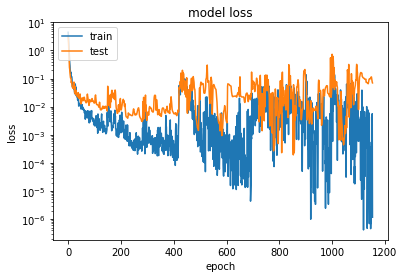

<Figure size 432x288 with 0 Axes>

In [14]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

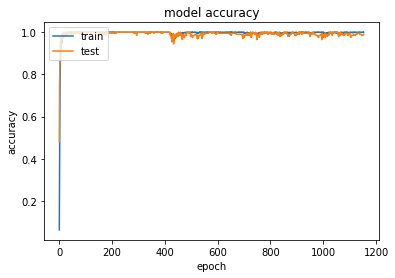

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')